## To reproduce our work, please follow the instructions in the README. 

In [ ]:
!pip install pyspellchecker
!pip install emoji
!pip install pyLDAvis

     |████████████████████████████████| 1.9MB 6.1MB/s 
     |████████████████████████████████| 51kB 3.2MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49715 sha256=24d444293fdc18e87a89cd57b94c07e8e93755a176931a9cb0e66efd388786d9
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji
     |████████████████████████████████| 1.6MB 7.2MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=cbdb8952c520e267577b88914352fbef13e44830e381e06ad9a5df204b0d6e98
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import nltk
import string
import emoji
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
from tqdm import tqdm
from gensim.parsing.preprocessing import remove_stopwords
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA #standardize
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/Shared drives/CIS 520 final project/tweets.csv')
df.shape

(11370, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11370 non-null  int64 
 1   keyword   11370 non-null  object
 2   location  7952 non-null   object
 3   text      11370 non-null  object
 4   target    11370 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 444.3+ KB


# **Data Cleaning** 

In [ ]:
# remove url
def remove_url(text):
    text = re.compile(r'https?://\S+|www\.\S+').sub(r'',text)
    return text

#remove html tags
def remove_html(text):
    text = re.compile(r'<.*?>').sub(r'',text)
    return text

def remove_emoji(text):
    text = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE).sub(r'',text)
    text = emoji.demojize(text)
    text = re.sub(':\S+?:', ' ', text)
    return text

def remove_punctuation(text):
    text = text.translate(str.maketrans('','', string.punctuation))
    return text

def remove_stopword(text):
    text = remove_stopwords(text)
    return text

In [ ]:
df['text'] = df['text'].apply(lambda x:remove_url(x))
df['text'] = df['text'].apply(lambda x:remove_html(x))
df['text'] = df['text'].apply(lambda x:remove_emoji(x))
df['text'] = df['text'].apply(lambda x:remove_punctuation(x))
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply(lambda x:remove_stopword(x))

# **Data Visualization**

In [ ]:
# Helper function
def plot_20_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='20 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


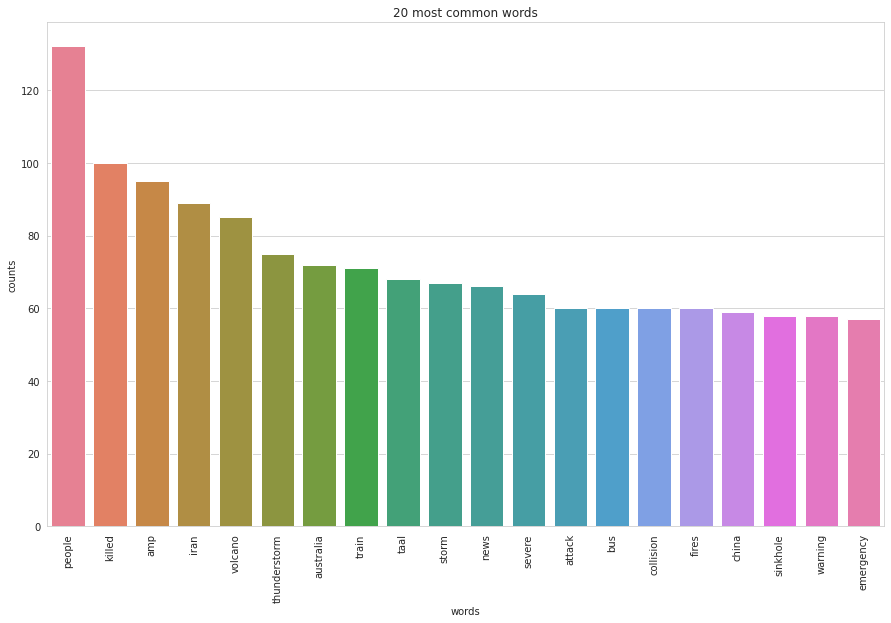

In [ ]:
# select text with target = 1
df_disaster = df[df.target == 1]

count_vectorizer_text = CountVectorizer()
text_data = count_vectorizer_text.fit_transform(df_disaster['text'])
plot_20_most_common_words(text_data, count_vectorizer_text)

In [ ]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [ ]:
number_topics = 10
number_words = 10

# Create and fit the LDA model
text_lda = LDA(n_components=number_topics)
text_lda.fit(text_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(text_lda, count_vectorizer_text, number_words)

Topics found via LDA:

Topic #0:
train hitchin freight derailed derailment thunderstorm morning chemical hazard massive

Topic #1:
volcano taal eruption philippines amp australia animals bushfires british dead

Topic #2:
iran people killed ukrainian tornado plane home nuclear powerful flattened

Topic #3:
body parts bag storm north woman air dublin area quarantined

Topic #4:
iran months venice people dry attack early floods severe amp

Topic #5:
nc thunderstorm severe warning avalanche weather alert australia est amp

Topic #6:
suicide outbreak pakistan 15 hi death service freight bombing virus

Topic #7:
earthquake puerto rico hit storm magnitude attack people iran israel

Topic #8:
bus sinkhole china swallows people killed dead huge ground pedestrians

Topic #9:
emergency services collision lanes road closed people helicopter train scene


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
if 1 == 1:

    LDAvis_prepared = sklearn_lda.prepare(text_lda, text_data, count_vectorizer_text)

    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
with open(LDAvis_data_filepath,'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.080843  0.162761       1        1  12.028676
3     -0.004894 -0.105361       2        1  11.101681
2      0.108172  0.038631       3        1  10.952618
5      0.030747  0.003872       4        1  10.797999
0     -0.134795  0.074674       5        1  10.571209
6     -0.174405  0.029342       6        1   9.339032
9      0.024726 -0.050779       7        1   9.176401
8     -0.016636 -0.088954       8        1   8.962015
7      0.045710 -0.079440       9        1   8.811092
4      0.040534  0.015254      10        1   8.259276, topic_info=           Term       Freq      Total Category  logprob  loglift
1118        bus  45.000000  45.000000  Default  30.0000  30.0000
5250   sinkhole  44.000000  44.000000  Default  29.0000  29.0000
1310      china  45.000000  45.000000  Default  28.0000  28.0000
5906      train  55.000000  55.000000  Default  27.0000  27.0000
5634   swallows  31.000000  31.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
558         amp   6.833287  73.888826  Topic10  -5.5474   0.1131
3209     killed   6.430237  76.963395  Topic10  -5.6082   0.0115
727   australia   5.517956  56.542698  Topic10  -5.7612   0.1668
3945       news   5.279684  51.404939  Topic10  -5.8053   0.2180
3569        man   4.555866  33.064403  Topic10  -5.9528   0.5118

[634 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2         1  0.760880           0100
35        6  0.659362         10year
89        2  0.169452             15
89        3  0.042363             15
89        4  0.042363             15
...     ...       ...            ...
6457      3  0.648607        zakzaky
6459      1  0.635273  zariagenocide
6460      3  0.648607  zariamassacre
6463      3  0.809658           zero
6464      5  0.928371         zhuhai

[1369 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 6, 1, 7, 10, 9, 8, 5])

# **Data Modeling and Prediction**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import LatentDirichletAllocation as LDA

### **Word Embedding**

In [ ]:
############################## Bag of Words #########################
def BOW(corpus):
  vectorizer = CountVectorizer(max_features=10000) # corpus is a list of str
  X = vectorizer.fit_transform(corpus).toarray()
  return vectorizer, X

############################### Glove ################################
def create_corpus_new(df):
    corpus=[]
    for tweet in df['text']:
        words=[word.lower() for word in word_tokenize(tweet)]
        corpus.append(words)
    return corpus

def glove(df):
  corpus=create_corpus_new(df)
  embedding_dict={}
  with open('/content/drive/Shared drives/CIS 520 final project/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
  f.close()

  MAX_LEN=50
  tokenizer_obj=Tokenizer()
  tokenizer_obj.fit_on_texts(corpus)
  sequences=tokenizer_obj.texts_to_sequences(corpus)

  tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post') 

  return  tweet_pad


############################ TF-IDF ###########################
def tfidf(X):
  tv = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None)
  X = tv.fit_transform(X)
  return tv,X

### **Machine Learning Model**

In [ ]:
##################### Logistic Regression #####################
def LR(X, y):
  clf = LogisticRegression(random_state=0,max_iter=1000).fit(X, y)
  return clf

#################### SVM ######################################
def SVM(X, y, kernel):
  clf = svm.SVC(kernel=kernel)
  clf.fit(X, y)
  return clf

#################### KNN ######################################
def knn(X,y,n):
  clf = KNeighborsClassifier(n_neighbors=n)
  clf.fit(X,y)
  return clf

#################### Random Forest ############################
def rf(X,y,n):
  clf = RandomForestClassifier(n_estimators=n)
  clf.fit(X,y)
  return clf

### **Model Evaluation**

In [ ]:
##################### ROC curve ###############################
def plot_roc(model, X_test, y_test):
    fpr, tpr, thresholds = roc_curve(y_test, model.decision_function(X_test))
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    return fpr, tpr, thresholds

### **Bag of Words + Logistic Regression**

In [ ]:
#### Bag of Words Plus Logistic Regression

vectorizer, X = BOW(df['text'])
y = df['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

clf = LR(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.9023746701846965

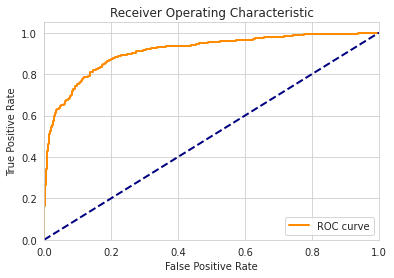

AUC: 0.9097121373479202


In [ ]:
fpr, tpr, thresholds = plot_roc(clf,X_test,y_test)
print('AUC:',auc(fpr,tpr))

### **Bag of Words + KNN**

In [ ]:
#### Bag of Words Plus KNN

vectorizer, X = BOW(df['text'])
y = df['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

clf = knn(X_train,y_train,10)
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.8447669305189094

### **Bag of Words + PCA + SVM**

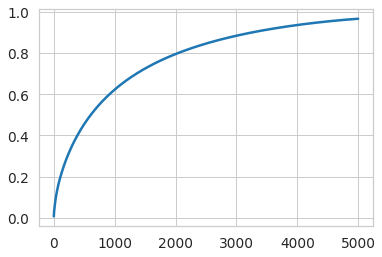

In [ ]:
#### select a proper value of component
vectorizer, X = BOW(df['text'])
y = df['target']
pca = PCA(n_components = 5000)
pca.fit(X)
pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(pc_vs_variance)
plt.show()

In [ ]:
# Based on the plot, go with n_components = 5000
vectorizer, X = BOW(df['text'])
y = df['target']
pca = PCA(n_components=5000)
X = pca.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [ ]:
clf = SVM(X_train, y_train, kernel = 'linear')
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.8768689533861038

### **Bag of Words + PCA + Random Forest**

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.8557607739665787

### **TF-IDF + Logistic Regression**

In [ ]:
#### TF-IDF Vectorizer Plus Logistic Regression

tv,X = tfidf(df['text'])
y = df['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

clf = LR(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.8975373790677221

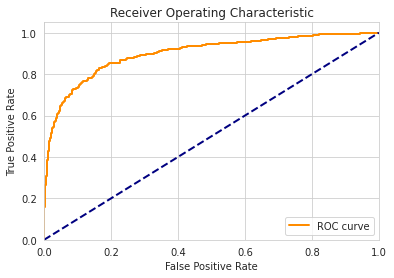

AUC: 0.8996958401910479


In [ ]:
fpr, tpr, thresholds = plot_roc(clf,X_test,y_test)
print('AUC:',auc(fpr,tpr))

### **TF-IDF + KNN**

In [ ]:
#### TF-IDF Vectorizer Plus KNN

tv,X = tfidf(df['text'])
y = df['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

clf = knn(X_train,y_train,10)
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.8390501319261213

### **TF-IDF + SVM**

In [ ]:
#### select a proper value of component
tv,X = tfidf(df['text'])
y = df['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

clf = SVM(X_train, y_train, kernel = 'rbf')
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.8913808267370272

In [ ]:
Cs = [0.1, 1, 1.25, 1.5]
gammas = [0.001, 0.05, 0.075, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=5, scoring='accuracy') #Uses 5-fold CV
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
accuracy_score(y_test,y_pred)

0.9010554089709762

In [ ]:
grid_search.best_params_

{'C': 1.5, 'gamma': 0.001}

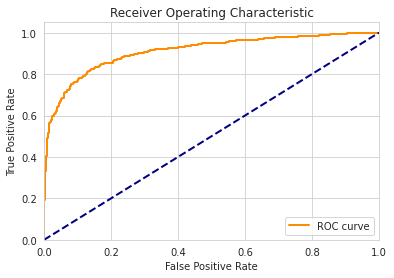

AUC: 0.9106022955863211


In [ ]:
fpr, tpr, thresholds = plot_roc(grid_search,X_test,y_test)
print('AUC:',auc(fpr,tpr))

### **TF-IDF + Random Forest**

In [ ]:
tv,X = tfidf(df['text'])
y = df['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

clf = RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.8988566402814424

### **Glove + Logistic Regression**

In [ ]:
#### Glove Plus Logistic Regression

X = glove(df)
y = df['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

clf = LR(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.8258575197889182

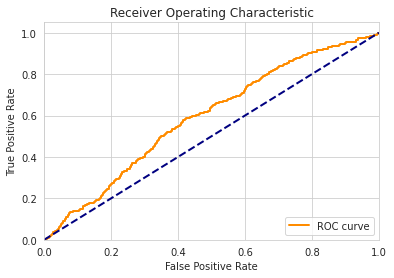

AUC: 0.5917952151977711


In [ ]:
fpr, tpr, thresholds = plot_roc(clf,X_test,y_test)
print('AUC:',auc(fpr,tpr))

### **Glove + KNN**

In [ ]:
#### Glove Plus KNN
X = glove(df)
y = df['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

clf = knn(X_train,y_train,10)
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.8197009674582234

### **Glove + PCA + SVM**

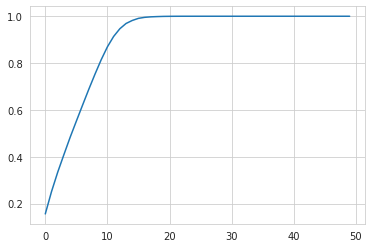

In [ ]:
# select the number of principal components
X = glove(df)
y = df['target']
pca = PCA()
pca.fit(X)
pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(pc_vs_variance)
plt.show()

In [ ]:
pca = PCA(n_components=20)
X = pca.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

clf = SVM(X_train, y_train, kernel = 'rbf')
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.8258575197889182

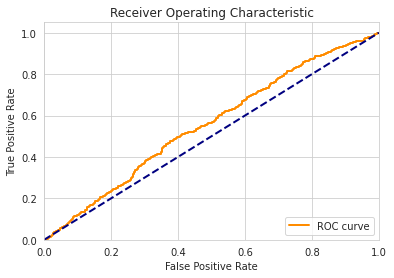

AUC: 0.5540226546616323


In [ ]:
fpr, tpr, thresholds = plot_roc(clf,X_test,y_test)
print('AUC:',auc(fpr,tpr))

### **Glove + PCA + Random Forest**

In [ ]:
X = glove(df)
y = df['target']
pca = PCA(n_components=20)
X = pca.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

clf = RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.8306948109058927